# Наблюдения(5 баллов)

По сути мое решение очень простое: автоматически генерирую признаки (максимум,среднее,мода, первый элемент и так далее... но в итоге оставил только максимумы, чтобы модель не занимала слишком много места), но есть две вещи, которые я нашел в данных и они бустанули мой скор на лидерборде на 1%

In [26]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
from utils import read_file,read_files,feature_eng,add_tax,to_pandas
from wandb.lightgbm import wandb_callback, log_summary
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin
import lightgbm as lgb
import warnings
from IPython.display import Image

# 1-ая особенность

In [5]:
ROOT = Path("aim-2024-local-contest-home-credit")
TRAIN_DIR = ROOT / "parquet_files" / "train"
train_data = pl.read_parquet(ROOT /"parquet_files"/ "train_base_table.parquet")
default = train_data.filter(pl.col('target') == 1)["case_id"].to_list()
not_default = train_data.filter(pl.col('target') == 0)["case_id"].to_list()

In [6]:
researcha = pl.read_parquet(TRAIN_DIR / "train_tax_registry_a_1.parquet")
researchb = pl.read_parquet(TRAIN_DIR / "train_tax_registry_b_1.parquet")
researchc = pl.read_parquet(TRAIN_DIR / "train_tax_registry_c_1.parquet")


In [7]:
researchb.filter(pl.col('case_id').is_in(default))

case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
i64,f64,str,str,i64


In [8]:
researchb.filter(pl.col('case_id').is_in(not_default))

case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
i64,f64,str,str,i64


Трейна нет в tax_b! Но зато Тест практически весь лежит в tax_b

In [10]:
#researchbt = pl.read_parquet(PATH / "test_tax_registry_b_1.parquet")
test_data = pl.read_parquet(ROOT /"parquet_files"/ "test_base_table.parquet")
cs = test_data["case_id"]

In [11]:
researchb.filter(pl.col('case_id').is_in(cs))

case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1
i64,f64,str,str,i64
49435,6885.0,"""2019-10-16""","""6b730375""",7
49435,6885.0,"""2019-10-16""","""6b730375""",1
49435,6885.0,"""2019-10-16""","""6b730375""",8
49435,6885.0,"""2019-10-16""","""6b730375""",3
49435,6885.0,"""2019-10-16""","""6b730375""",4
…,…,…,…,…
2703452,7290.0,"""2020-06-11""","""ad68e80f""",2
2703452,10638.0,"""2020-08-05""","""ad68e80f""",4
2703452,15552.0,"""2020-07-07""","""3ba7682e""",3


В результате пришел к выводу, что надо склеивать все три файла в один( у них как раз совпадают структуры), а не генерировать на каждом новые фичи. Как итог: 84% --> 85%

# 2-ая особенность

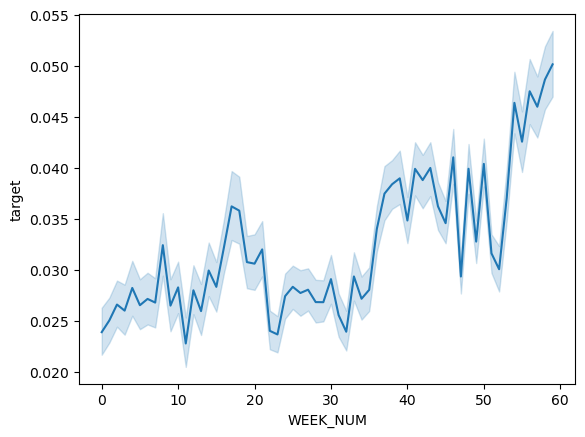

In [12]:
sns.lineplot(
    data=train_data,
    x="WEEK_NUM",
    y="target",
)
plt.show()

частота дефолта зависит от номера недели... данные неравномерные и отчетливо вырисовываются группы. Потому решил сделать кросс-валидацию,  обучить 5 моделей 

# Бейслайны(1+4 баллов) + Wandb+optuna(5 баллов)

Я свернул все функции обработки в utils.py, оставил только классы Pipline и Aggregator(которые я нашел в топовом решении оригинального соревнования, как базу для разметки данных)

In [24]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [25]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

# Считывание и обработка

In [6]:
ROOT            = Path("/kaggle/input/aim-2024-local-contest-home-credit2")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [7]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        #read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        #read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        #read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [11]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 462)


In [12]:
df_train = add_tax(df_train,TRAIN_DIR / "train_tax_registry_a_1.parquet",TRAIN_DIR / "train_tax_registry_b_1.parquet",TRAIN_DIR / "train_tax_registry_c_1.parquet")

In [13]:
df_train = df_train.pipe(Pipeline.handle_dates)

In [14]:
df_train = df_train.pipe(Pipeline.filter_cols)

print("train data shape:\t", df_train.shape)

train data shape:	 (1613825, 358)


In [15]:
df_train, cat_cols = to_pandas(df_train)

In [16]:
del data_store

gc.collect()

169

из-за склеивания файлов  "tax" появилось немного дупликатов

In [17]:
mask = df_train.duplicated(subset=["case_id"],keep = "last")
df_train = df_train.loc[~mask]

ищем лучшие параметры модели с помощью optuna и логируем в wandb

In [18]:
import wandb
wandb.login()

wandb: Currently logged in as: sheinov2023. Use `wandb login --relogin` to force relogin


True

In [22]:
import optuna
from wandb.lightgbm import wandb_callback, log_summary

def my_objective(trial, X_train, y_train, X_valid, y_valid,k):
    
    params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.3, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.3, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 3, 10),
        "n_estimators": 1000,
        "verbose": -1,
        "device" : "gpu"
    }
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lgb.log_evaluation(200), lgb.early_stopping(10),wandb_callback()]
    )
    
    return gbm.best_score["valid_0"]["auc"]

In [32]:
!pip install optuna_integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 937.8 kB/s eta 0:00:000:00:01


In [21]:
gc.collect()

2804

In [23]:
from functools import partial
from optuna.integration.wandb import WeightsAndBiasesCallback
df = df_train[df_train["WEEK_NUM"] < 60]
X_train = df.drop(columns=["target", "case_id", "WEEK_NUM"])
y_train = df["target"]
weeks = df["WEEK_NUM"]

df_test = df_train[df_train["WEEK_NUM"] >= 60]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

fitted_models = []
cv_scores = []

ks=1
for idx_train, idx_valid in cv.split(X_train, y_train, groups=weeks):#   Because it takes a long time to divide the data set, 
    gc.collect()
    wandb_kwargs = {"project": "optuna-wandb"}
    wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)
    X_tr, y_tr = X_train.iloc[idx_train], y_train.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_val, y_val = X_train.iloc[idx_valid], y_train.iloc[idx_valid]
    obj_func = partial(my_objective, X_train=X_tr, X_valid=X_val, y_train=y_tr, y_valid=y_val,k=ks)
    study = optuna.create_study(direction="maximize")
    study.optimize(obj_func, n_trials=3, callbacks=[wandbc])
    best_params = study.best_params
    fitted_models.append(best_params)
    ks+=1

/tmp/ipykernel_245/2039480239.py:19: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)


iteration,▁▂▂▃▃▃▄▄▅▆▆▇▇██▁▂▂▃▃▄▄▅▅▆▆▇▇█▁▁▂▂▃▃▄▄▅▅▆
valid_0_auc,▅▇▇▇███████████▅▇▇▇██████████▁▅▆▇▇▇▇▇▇██
iteration,99


[I 2024-04-16 21:14:29,965] A new study created in memory with name: no-name-6d961ba9-00a6-4f1e-945c-c2bbda525a91
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning genera

Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:15:12,859] Trial 0 finished with value: 0.8360093750496286 and parameters: {'max_depth': 4, 'num_leaves': 37, 'learning_rate': 0.14701873384229036, 'feature_fraction': 0.7786380257778734, 'bagging_fraction': 0.44188501715666806, 'bagging_freq': 5}. Best is trial 0 with value: 0.8360093750496286.


Early stopping, best iteration is:
[174]	valid_0's auc: 0.836009


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 184. Dropping entry: {'max_depth': 4, 'num_leaves': 37, 'learning_rate': 0.14701873384229036, 'feature_fraction': 0.7786380257778734, 'bagging_fraction': 0.44188501715666806, 'bagging_freq': 5, 'auc': 0.8360093750496286, '_timestamp': 1713302112.8621933}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:15:47,809] Trial 1 finished with value: 0.8324799304801489 and parameters: {'max_depth': 10, 'num_leaves': 23, 'learning_rate': 0.16957856393580673, 'feature_fraction': 0.5850590400627441, 'bagging_fraction': 0.32418534700668544, 'bagging_freq': 5}. Best is trial 0 with value: 0.8360093750496286.


Early stopping, best iteration is:
[79]	valid_0's auc: 0.83248


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING (User provided step: 1 is less than current step: 273. Dropping entry: {'max_depth': 10, 'num_leaves': 23, 'learning_rate': 0.16957856393580673, 'feature_fraction': 0.5850590400627441, 'bagging_fraction': 0.32418534700668544, 'bagging_freq': 5, 'auc': 0.8324799304801489, '_timestamp': 1713302147.8111377}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:16:27,203] Trial 2 finished with value: 0.8379758549288144 and parameters: {'max_depth': 6, 'num_leaves': 34, 'learning_rate': 0.1755580790356044, 'feature_fraction': 0.840191362814156, 'bagging_fraction': 0.7210234292757551, 'bagging_freq': 9}. Best is trial 2 with value: 0.8379758549288144.


Early stopping, best iteration is:
[121]	valid_0's auc: 0.837976


/tmp/ipykernel_245/2039480239.py:19: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)


iteration,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██▁▁▂▂▃▃▃▄▄▁▁▂▂▃▃▄▄▄▅▅▆▆
valid_0_auc,▁▄▆▆▇▇▇▇▇█████████▂▅▆▇▇▇▇▇█▄▆▇▇▇████████
iteration,130


[I 2024-04-16 21:16:52,815] A new study created in memory with name: no-name-5e1c4d9d-1263-4cab-8036-42b2d281d747
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:17:44,858] Trial 0 finished with value: 0.8474908996783524 and parameters: {'max_depth': 8, 'num_leaves': 33, 'learning_rate': 0.10086487959939754, 'feature_fraction': 0.6169702221225986, 'bagging_fraction': 0.638585932576109, 'bagging_freq': 9}. Best is trial 0 with value: 0.8474908996783524.


Early stopping, best iteration is:
[182]	valid_0's auc: 0.847491


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 192. Dropping entry: {'max_depth': 8, 'num_leaves': 33, 'learning_rate': 0.10086487959939754, 'feature_fraction': 0.6169702221225986, 'bagging_fraction': 0.638585932576109, 'bagging_freq': 9, 'auc': 0.8474908996783524, '_timestamp': 1713302264.8610878}).


Training until validation scores don't improve for 10 rounds
[200]	valid_0's auc: 0.843318
[400]	valid_0's auc: 0.848155
[600]	valid_0's auc: 0.84996


[I 2024-04-16 21:19:20,650] Trial 1 finished with value: 0.8499793116366977 and parameters: {'max_depth': 3, 'num_leaves': 23, 'learning_rate': 0.10292612646047442, 'feature_fraction': 0.6019370147015224, 'bagging_fraction': 0.9997200830825637, 'bagging_freq': 9}. Best is trial 1 with value: 0.8499793116366977.


Early stopping, best iteration is:
[602]	valid_0's auc: 0.849979


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING (User provided step: 1 is less than current step: 804. Dropping entry: {'max_depth': 3, 'num_leaves': 23, 'learning_rate': 0.10292612646047442, 'feature_fraction': 0.6019370147015224, 'bagging_fraction': 0.9997200830825637, 'bagging_freq': 9, 'auc': 0.8499793116366977, '_timestamp': 1713302360.6522896}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:19:59,492] Trial 2 finished with value: 0.8435447254871559 and parameters: {'max_depth': 10, 'num_leaves': 37, 'learning_rate': 0.15423792197522004, 'feature_fraction': 0.6931106945598232, 'bagging_fraction': 0.5912573395507426, 'bagging_freq': 10}. Best is trial 1 with value: 0.8499793116366977.


Early stopping, best iteration is:
[118]	valid_0's auc: 0.843545


/tmp/ipykernel_245/2039480239.py:19: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)


iteration,▁▁▂▂▂▂▃▃▃▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██▁▁▂▂▂▂
valid_0_auc,▂▅▇▇▇████▃▅▆▆▇▇▇▇▇▇███████████████▁▆▇▇▇▇
iteration,127


[I 2024-04-16 21:20:22,654] A new study created in memory with name: no-name-9a2d0fe8-9f06-4b48-9278-42bd66325d30
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:21:19,383] Trial 0 finished with value: 0.8434093556674601 and parameters: {'max_depth': 8, 'num_leaves': 41, 'learning_rate': 0.14576425947651273, 'feature_fraction': 0.37558834451220335, 'bagging_fraction': 0.8837373896946614, 'bagging_freq': 9}. Best is trial 0 with value: 0.8434093556674601.


Early stopping, best iteration is:
[167]	valid_0's auc: 0.843409


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 177. Dropping entry: {'max_depth': 8, 'num_leaves': 41, 'learning_rate': 0.14576425947651273, 'feature_fraction': 0.37558834451220335, 'bagging_fraction': 0.8837373896946614, 'bagging_freq': 9, 'auc': 0.8434093556674601, '_timestamp': 1713302479.3855736}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:22:13,526] Trial 1 finished with value: 0.8438210185025343 and parameters: {'max_depth': 10, 'num_leaves': 28, 'learning_rate': 0.13310864186611604, 'feature_fraction': 0.596237601366723, 'bagging_fraction': 0.941145711831417, 'bagging_freq': 3}. Best is trial 1 with value: 0.8438210185025343.


Early stopping, best iteration is:
[180]	valid_0's auc: 0.843821


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING (User provided step: 1 is less than current step: 367. Dropping entry: {'max_depth': 10, 'num_leaves': 28, 'learning_rate': 0.13310864186611604, 'feature_fraction': 0.596237601366723, 'bagging_fraction': 0.941145711831417, 'bagging_freq': 3, 'auc': 0.8438210185025343, '_timestamp': 1713302533.5284936}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:22:47,898] Trial 2 finished with value: 0.8360354329652405 and parameters: {'max_depth': 6, 'num_leaves': 21, 'learning_rate': 0.18897402355149223, 'feature_fraction': 0.7598449927184217, 'bagging_fraction': 0.3647691713339983, 'bagging_freq': 8}. Best is trial 1 with value: 0.8438210185025343.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.836035


/tmp/ipykernel_245/2039480239.py:19: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)


iteration,▁▂▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▃▃▃▄▄▅▆▆▆▇▇█▁▂▂▂▃▄▄▅▅▅▆
valid_0_auc,▂▅▇▇▇█████████▁▅▆▇▇▇█████████▂▅▆▇▇▇▇▇▇▇▇
iteration,132


[I 2024-04-16 21:23:12,563] A new study created in memory with name: no-name-63403e14-2e6a-40a3-8757-9fd9060025c5
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[200]	valid_0's auc: 0.848456


[I 2024-04-16 21:24:05,725] Trial 0 finished with value: 0.8494819926913381 and parameters: {'max_depth': 5, 'num_leaves': 20, 'learning_rate': 0.139328265449337, 'feature_fraction': 0.7434067516880435, 'bagging_fraction': 0.9115000016575576, 'bagging_freq': 3}. Best is trial 0 with value: 0.8494819926913381.


Early stopping, best iteration is:
[280]	valid_0's auc: 0.849482


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 290. Dropping entry: {'max_depth': 5, 'num_leaves': 20, 'learning_rate': 0.139328265449337, 'feature_fraction': 0.7434067516880435, 'bagging_fraction': 0.9115000016575576, 'bagging_freq': 3, 'auc': 0.8494819926913381, '_timestamp': 1713302645.7278047}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:24:45,125] Trial 1 finished with value: 0.8440331112801651 and parameters: {'max_depth': 8, 'num_leaves': 37, 'learning_rate': 0.12693929088270223, 'feature_fraction': 0.7741386382807025, 'bagging_fraction': 0.46408041374095965, 'bagging_freq': 9}. Best is trial 0 with value: 0.8494819926913381.


Early stopping, best iteration is:
[120]	valid_0's auc: 0.844033


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING (User provided step: 1 is less than current step: 420. Dropping entry: {'max_depth': 8, 'num_leaves': 37, 'learning_rate': 0.12693929088270223, 'feature_fraction': 0.7741386382807025, 'bagging_fraction': 0.46408041374095965, 'bagging_freq': 9, 'auc': 0.8440331112801651, '_timestamp': 1713302685.1285532}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:25:26,409] Trial 2 finished with value: 0.8449985090929019 and parameters: {'max_depth': 10, 'num_leaves': 24, 'learning_rate': 0.12854199605199065, 'feature_fraction': 0.8840196503147337, 'bagging_fraction': 0.6069910102863338, 'bagging_freq': 10}. Best is trial 0 with value: 0.8494819926913381.


Early stopping, best iteration is:
[152]	valid_0's auc: 0.844999


/tmp/ipykernel_245/2039480239.py:19: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(metric_name="auc", wandb_kwargs=wandb_kwargs)


iteration,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂▃▃▄▄▁▁▂▂▃▃▃▄▄▄▅
valid_0_auc,▃▅▆▇▇▇▇█████████████▃▆▇▇▇▇▇▇█▁▅▆▇▇▇▇████
iteration,161


[I 2024-04-16 21:25:50,312] A new study created in memory with name: no-name-ab8cb94f-52a2-4b54-9c65-b68987fba8e8
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[200]	valid_0's auc: 0.839916


[I 2024-04-16 21:26:49,135] Trial 0 finished with value: 0.8445864320702046 and parameters: {'max_depth': 3, 'num_leaves': 37, 'learning_rate': 0.11063857743926099, 'feature_fraction': 0.6345632363286258, 'bagging_fraction': 0.40473308530468166, 'bagging_freq': 7}. Best is trial 0 with value: 0.8445864320702046.
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 377. Dropping entry: {'max_depth': 3, 'num_leaves': 37, 'learning_rate': 0.11063857743926099, 'feature_fraction': 0.6345632363286258, 'bagging_fraction': 0.40473308530468166, 'bagging_freq': 7, 'auc': 0.8445864320702046, '_timestamp': 1713302809

Early stopping, best iteration is:
[367]	valid_0's auc: 0.844586
Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:27:28,980] Trial 1 finished with value: 0.8427906485458027 and parameters: {'max_depth': 8, 'num_leaves': 28, 'learning_rate': 0.18118254623158894, 'feature_fraction': 0.6237177471849509, 'bagging_fraction': 0.6726038499916795, 'bagging_freq': 9}. Best is trial 0 with value: 0.8445864320702046.


Early stopping, best iteration is:
[104]	valid_0's auc: 0.842791


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
wandb: WARNING (User provided step: 1 is less than current step: 491. Dropping entry: {'max_depth': 8, 'num_leaves': 28, 'learning_rate': 0.18118254623158894, 'feature_fraction': 0.6237177471849509, 'bagging_fraction': 0.6726038499916795, 'bagging_freq': 9, 'auc': 0.8427906485458027, '_timestamp': 1713302848.9822328}).


Training until validation scores don't improve for 10 rounds


[I 2024-04-16 21:28:05,339] Trial 2 finished with value: 0.8396391051926327 and parameters: {'max_depth': 9, 'num_leaves': 30, 'learning_rate': 0.15256036516054833, 'feature_fraction': 0.8167655820797681, 'bagging_fraction': 0.4309012602268121, 'bagging_freq': 6}. Best is trial 0 with value: 0.8445864320702046.


Early stopping, best iteration is:
[108]	valid_0's auc: 0.839639


wandb: WARNING (User provided step: 2 is less than current step: 609. Dropping entry: {'max_depth': 9, 'num_leaves': 30, 'learning_rate': 0.15256036516054833, 'feature_fraction': 0.8167655820797681, 'bagging_fraction': 0.4309012602268121, 'bagging_freq': 6, 'auc': 0.8396391051926327, '_timestamp': 1713302885.3412585}).


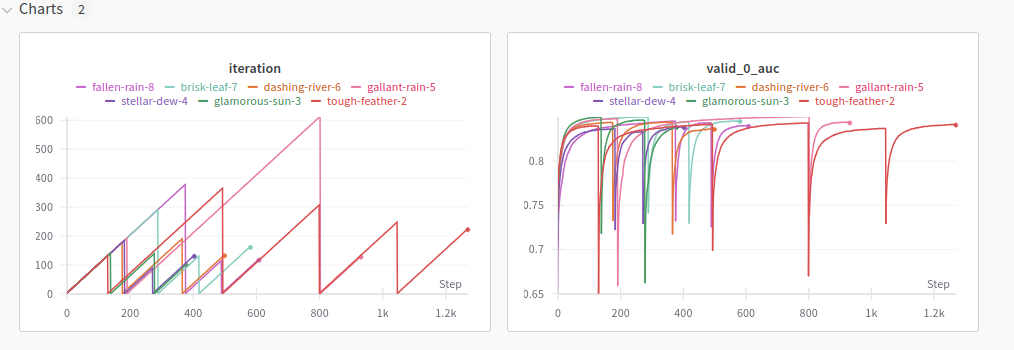

In [28]:
Image('optuna.png')

Выше приведен код с n_trails=5 на каждом сплите... я специально так сделал, чтобы показать, что код рабочий. Реальная optuna с n_trails=50, на которой я и подобрал лучшие параметры, у меня слетела. Выполняется эта ячейка очень долго... 

In [24]:
# Тут я разделяю разметку из оригинального соревнования
# Test не участвует в обучении
df = df_train[df_train["WEEK_NUM"] < 60]
X = df.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df["target"]
weeks = df["WEEK_NUM"]

df_test = df_train[df_train["WEEK_NUM"] >= 60]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "colsample_bytree": 0.7, 
    "colsample_bynode": 0.5,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

info = params.copy()


fitted_models = []
k = 0
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
        gc.collect()
        k+=1
        info["k"] = k
        wandb.init(
    # set the wandb project where this run will be logged
        project="ML2_HW3",
    # track hyperparameters and run metadata
        config=info
        )
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=lgb_valid,
            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10),wandb_callback()]
        )

        fitted_models.append(gbm)
        auc = gbm.best_score["valid_0"]["auc"]
        wandb.log({"best_auc": auc})

iteration,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇██▁▁▂▂▂▃▃▁▁▂▂▂▃▃▃
valid_0_auc,▁▃▅▆▆▇▇▇▇▇▇██████████████▆▇▇████▃▆▇▇▇███
iteration,117


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.817226
[100]	valid_0's auc: 0.831114
[150]	valid_0's auc: 0.836653
[200]	valid_0's auc: 0.839633
[250]	valid_0's auc: 0.841546
[300]	valid_0's auc: 0.842588
[350]	valid_0's auc: 0.84324
[400]	valid_0's auc: 0.843634
Early stopping, best iteration is:
[434]	valid_0's auc: 0.843807


best_auc,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_0_auc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████████████████████████
best_auc,0.84381
iteration,443


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.827078
[100]	valid_0's auc: 0.840068
[150]	valid_0's auc: 0.845493
[200]	valid_0's auc: 0.84833
[250]	valid_0's auc: 0.849898
[300]	valid_0's auc: 0.850981
[350]	valid_0's auc: 0.85152
[400]	valid_0's auc: 0.851856
Early stopping, best iteration is:
[438]	valid_0's auc: 0.851987


best_auc,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_0_auc,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
best_auc,0.85199
iteration,447


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.819824
[100]	valid_0's auc: 0.833898
[150]	valid_0's auc: 0.839585
[200]	valid_0's auc: 0.842398
[250]	valid_0's auc: 0.844485
[300]	valid_0's auc: 0.84576
[350]	valid_0's auc: 0.846643
[400]	valid_0's auc: 0.847163
Early stopping, best iteration is:
[427]	valid_0's auc: 0.847489


best_auc,▁
iteration,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_0_auc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
best_auc,0.84749
iteration,436


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.824875
[100]	valid_0's auc: 0.838711
[150]	valid_0's auc: 0.844448
[200]	valid_0's auc: 0.847484
[250]	valid_0's auc: 0.849277
[300]	valid_0's auc: 0.850658
[350]	valid_0's auc: 0.85134
[400]	valid_0's auc: 0.851651
[450]	valid_0's auc: 0.852044
[500]	valid_0's auc: 0.852398
[550]	valid_0's auc: 0.852619
[600]	valid_0's auc: 0.852805
Early stopping, best iteration is:
[616]	valid_0's auc: 0.852925


best_auc,▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_0_auc,▁▂▄▅▆▆▇▇▇▇▇▇▇███████████████████████████
best_auc,0.85292
iteration,625


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.821329
[100]	valid_0's auc: 0.83631
[150]	valid_0's auc: 0.84167
[200]	valid_0's auc: 0.844731
[250]	valid_0's auc: 0.846446
[300]	valid_0's auc: 0.847786
[350]	valid_0's auc: 0.848588
[400]	valid_0's auc: 0.84903
Early stopping, best iteration is:
[394]	valid_0's auc: 0.849063


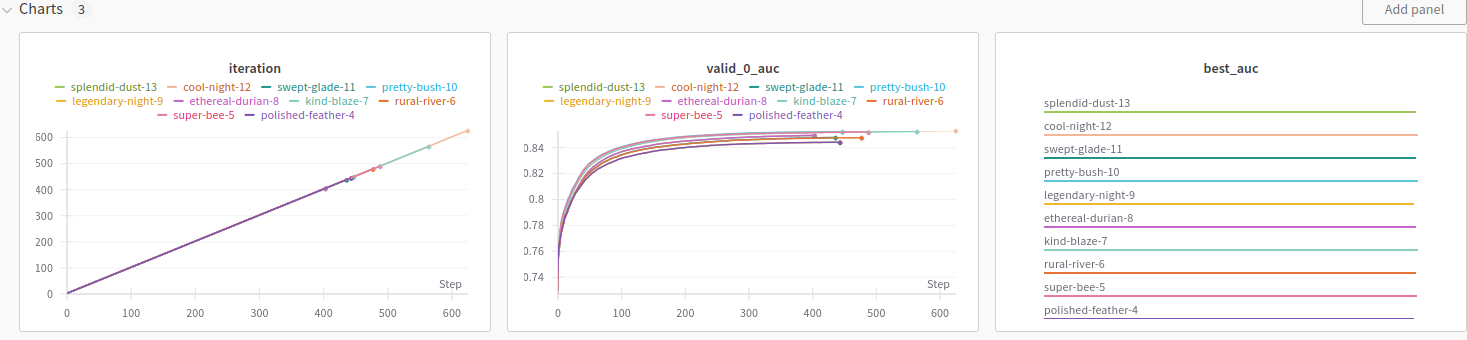

In [29]:
Image('cross.png')

In [25]:
fitted_models

In [26]:
from sklearn.metrics import roc_auc_score
gbm = fitted_models[3]
X_test = df_test.drop(columns=["WEEK_NUM","target"])
X_test = X_test.set_index("case_id")


y_pred = []
for model in fitted_models:
    y_pred.append(model.predict(X_test, num_iteration=model.best_iteration))

In [27]:
y_pr = np.array(y_pred)
y_pred = y_pr.mean(axis=0)

здесь, конечно же, test, а не train... 

In [28]:
print(f'The AUC score on the test set is: {roc_auc_score(df_test["target"], y_pred)}')

The AUC score on the train set is: 0.8597678387798257


In [30]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission21.csv")

# Интерпретация(5 баллов)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

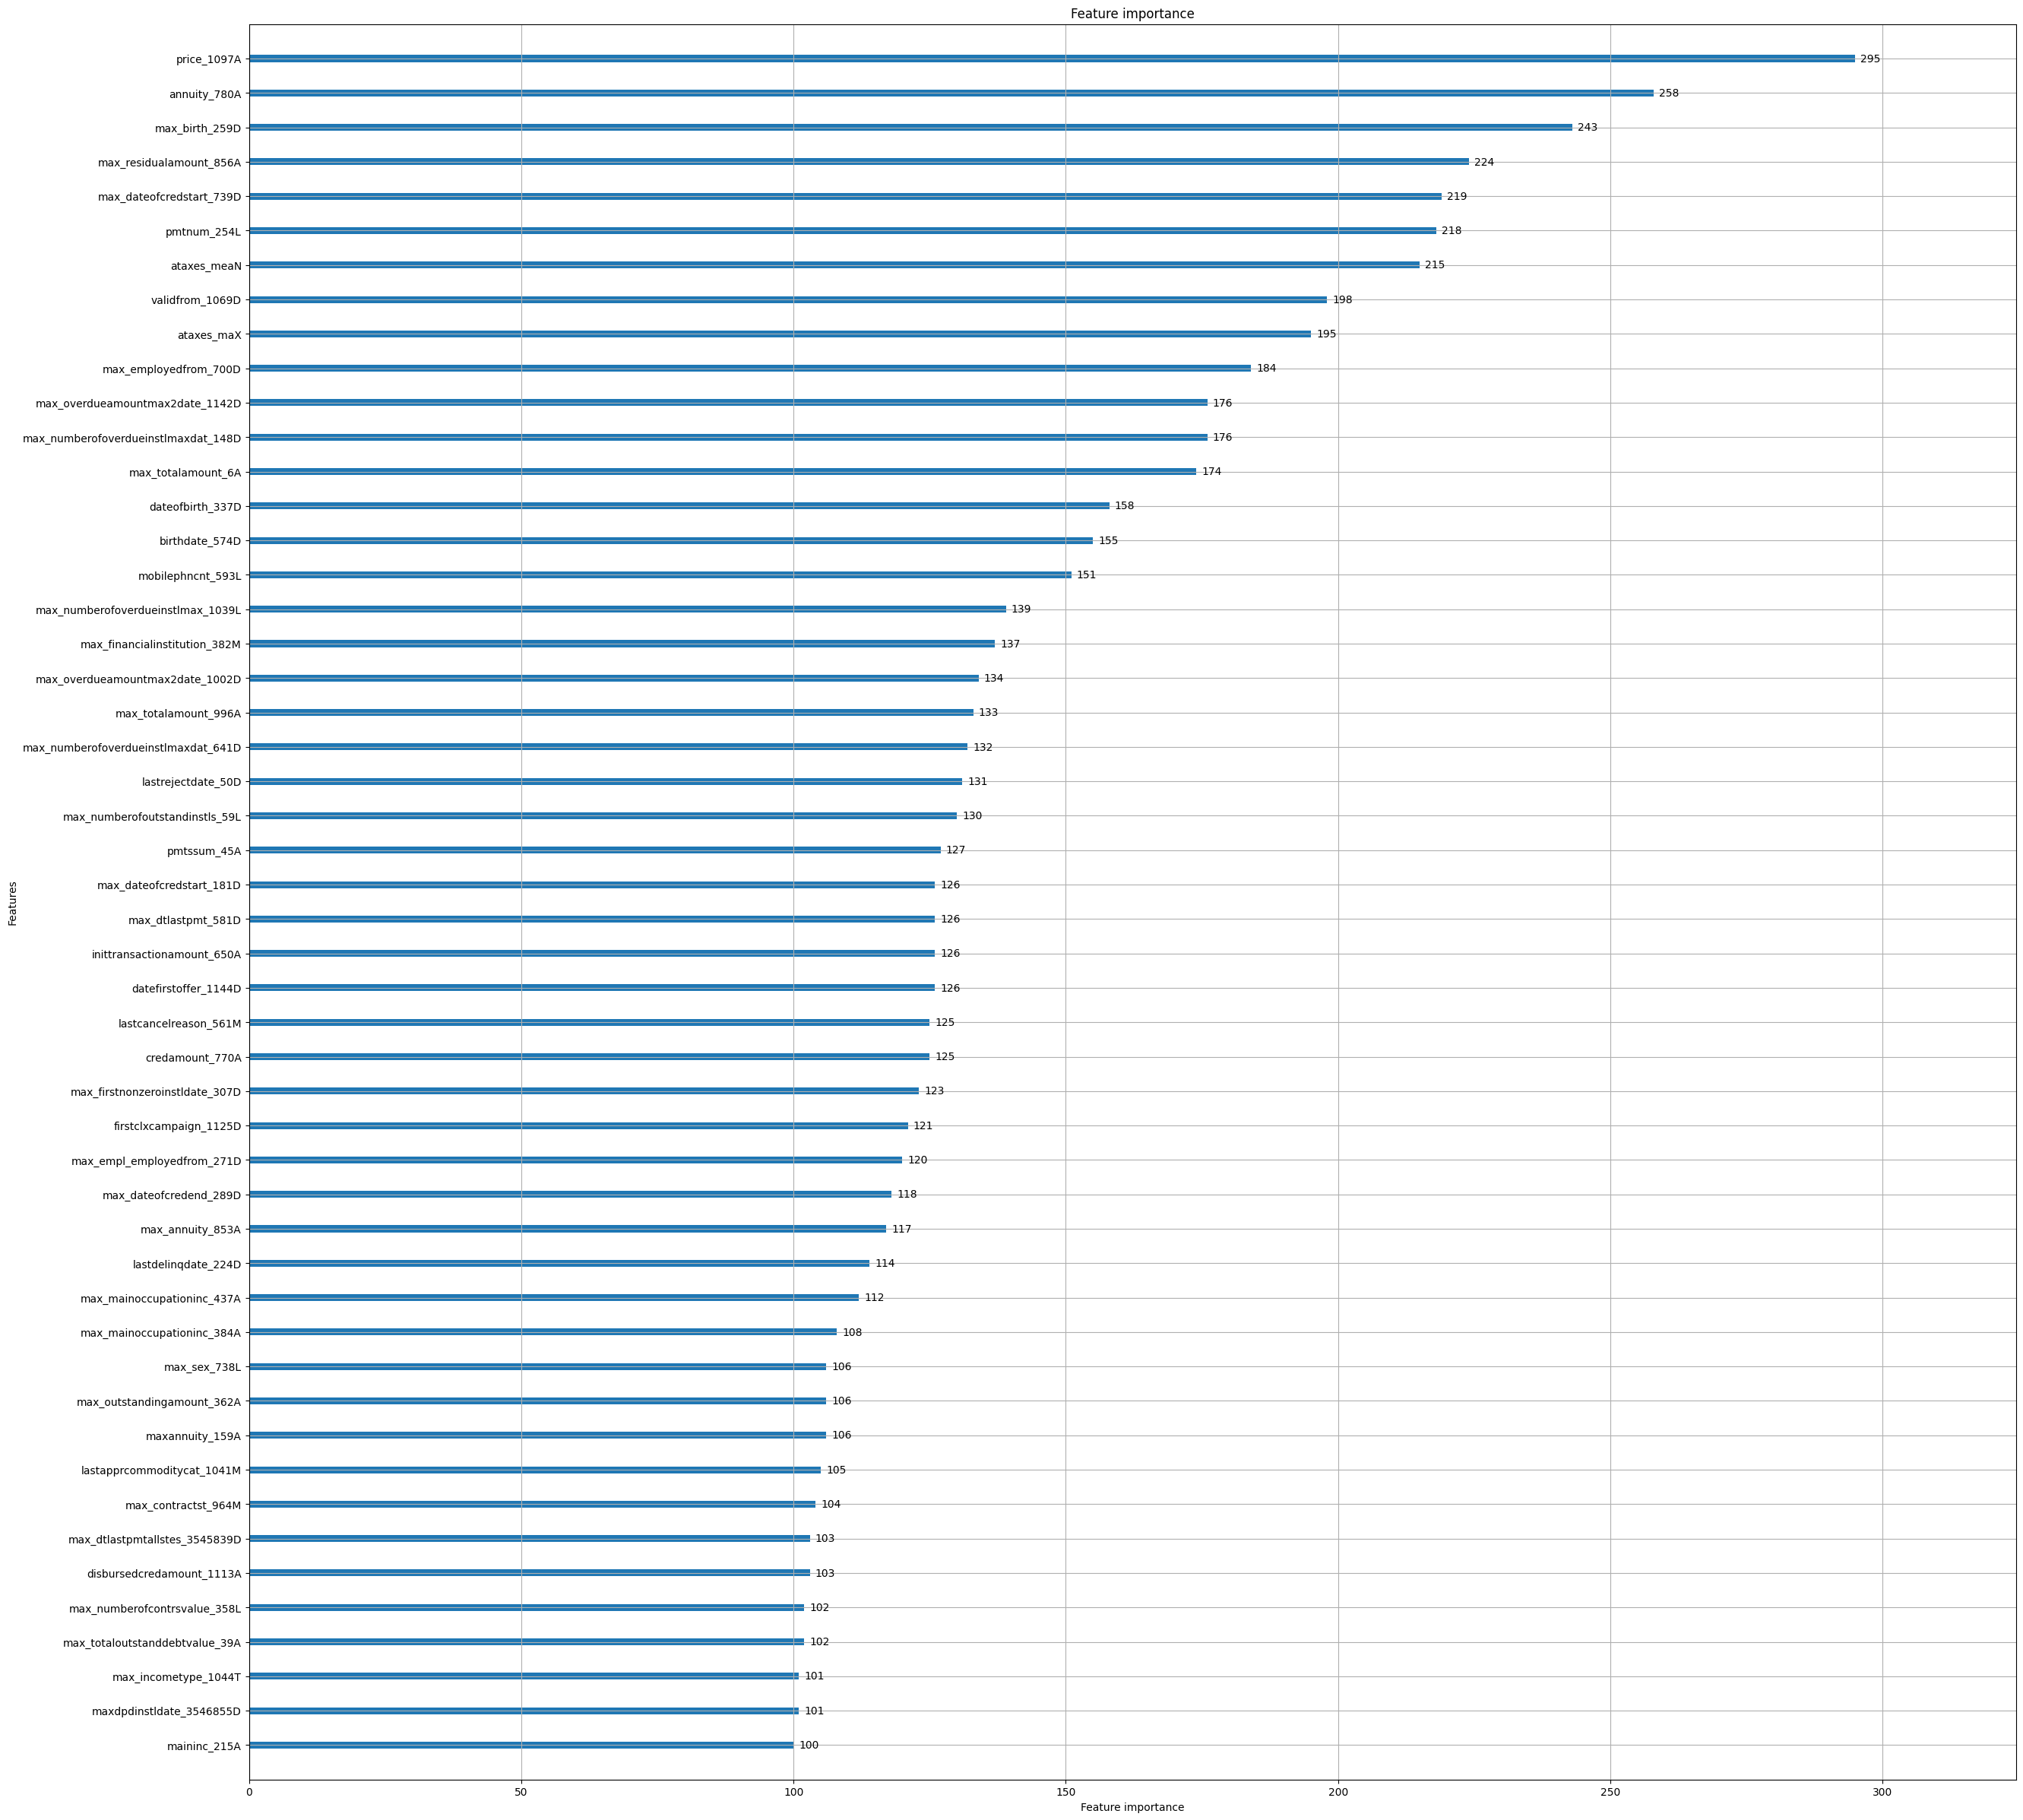

In [32]:
model = fitted_models[3]
lgb.plot_importance(model, max_num_features=50, figsize = (30,30))

Как будто неудивительно, что размер кредита, ежемесячный доход, образование, возраст(дата рождения), а также прочие денежные показатели влияют на вероятность дефолта. Попробуем найти что-нибудь интересное:$$\newline$$
1)phonecnT - Количество людей с одинаковым номером мобильного телефона вероятно говорит о риске дефолта$$\newline$$
2)lastapprcommoditycat_1041M - Товарная категория последних кредитных заявок, поданных заявителем. На что берут кредит, тоже важно... хотя в целом, наверное, очевидно...$$\newline$$
3)numberofoverdueinstlmax_1151L - Максимальное количество просроченных платежей по закрытому контракту. Стоит обратить внимание на то, как добросовестно выполнял человек свои долговые обязательства$$\newline$$

In [ ]:
gc.collect()

In [ ]:
cb_explainer = shap.TreeExplainer(model)
cb_shap_values = cb_explainer(X)
shap.plots.beeswarm(cb_shap_values, max_display=30)
plt.savefig('shap.png')

здесь у меня слетел ноутбук,  так что вставлю картинку с предыдущей итерации

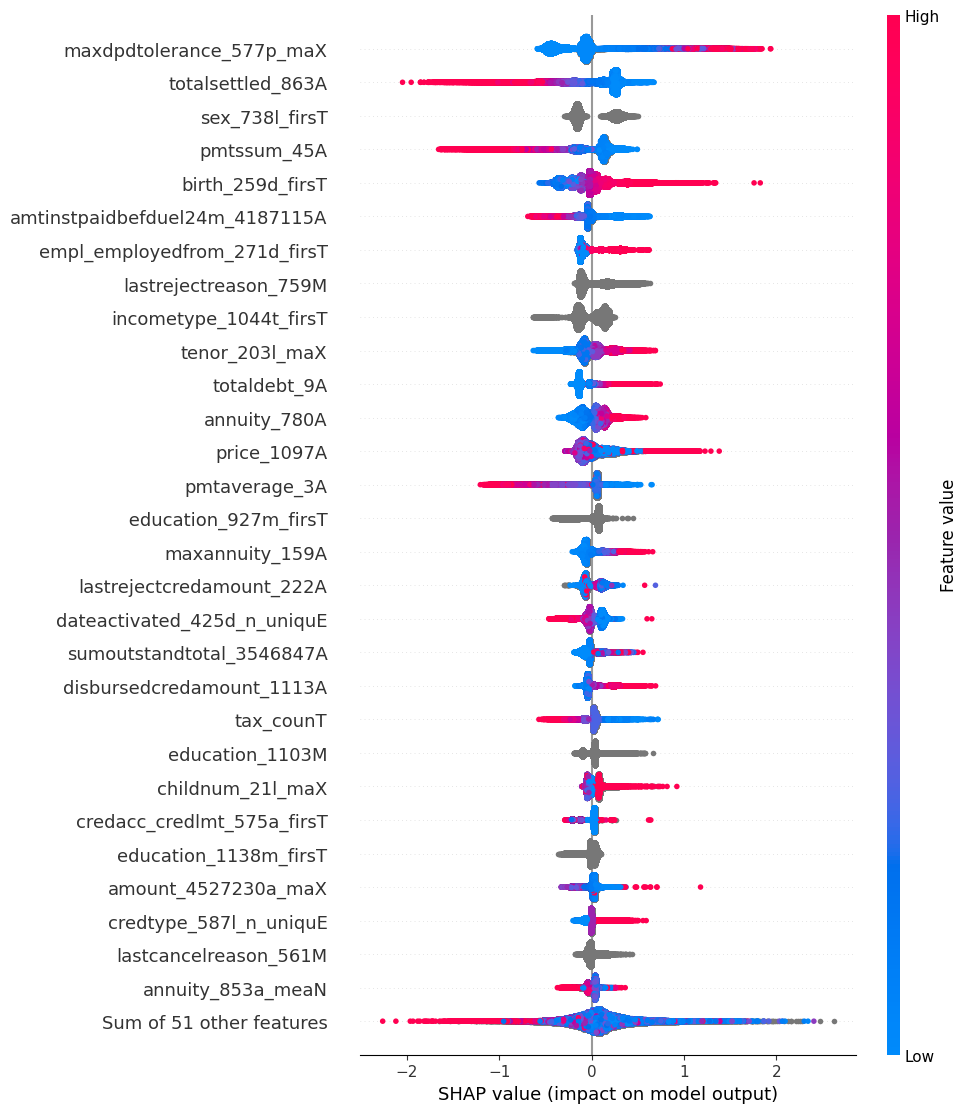

In [1]:
Image('shap.png')

Чем моложе кандидат, тем вероятнее он не выполнит свои обязательства.
То же и с количеством детей. Многодетные семью с большей вероятностью ждет дефолт
Количество различных типов кредитов, которые брал человек моежт говорить о его импульсивности и спонтанности... Такие могут не выполнить свои обязательства
Ну и из очевидного: люди с меньшим количеством записей в налоговой службе, скорее всего, не выплатят кредит)